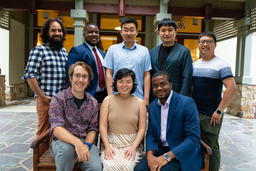

In [1]:
from PIL import Image
import requests
from io import BytesIO

size = (256, 256)
url = "https://cs.vt.edu/content/website_cs_vt_edu/en/faculty-search/jcr:content/article-image.transform/xl-medium/image.jpg"
response = requests.get(url)
content = BytesIO(response.content)
img = Image.open(content)
img.thumbnail(size, Image.LANCZOS)
img.show()

## Noise Process

$q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)$

$q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})$
### Reparametriation
$$
    \alpha_t = 1 - \beta_t \\
    \bar \alpha_t = \prod_{i=1}^t \alpha_i \\
    \epsilon \sim N(0, I)\\
    x_t = \sqrt{1-\beta_t}x_{t-1}+\sqrt{\beta_t}\epsilon\\
    = \sqrt{\alpha_t}x_{t-1} + \sqrt{1-\alpha_t}\epsilon\\
    = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1-\alpha_t\alpha_{t-1}}\epsilon\\
    = ... \\
    =\sqrt{\bar\alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon \\
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I) \\
$$

In [2]:
from enum import Enum, auto
class Beta():
  class schedule(Enum):
    linear = auto()
    cosin = auto()

  def __init__(self, start, end, times):
    """
    diffusion rate scheduler
    """
    self.start = start
    self.end = end
    self.times = times
    if not all([0.0 <= self.start < 1.0, 0.0 <= self.end < 1.0, self.start < self.end]):
      raise ValueError("Beta should between 0.0 and 1.0")

  def get_schedule(self, typeof: schedule):
    if typeof == Beta.schedule.linear:
      return np.linspace(self.start, self.end, self.times)
    elif typeof == Beta.schedule.cosin:
      """
      Alex Nichol, Prafulla Dhariwal (2021), Improved Denoising Diffusion Probabilistic Models
      \beta = 1 - \frac{\bar \alpha_t}{\bar \alpha_{t-1}}
      """
      import math
      def bar_alpha(t, s = 0.008):
        """
        f = cos(\frac{t/T+s}{1+s} \frac{\pi}{2})^2,\ where\ s=0.008
        """
        return (math.cos((t + s) / (1+s) * math.pi / 2) ** 2)
      clip_beta = 0.999
      return np.array([min(1 - bar_alpha((i) / self.times) / bar_alpha( (i-1) / self.times), clip_beta) for i in range(1, self.times+1)])
    return None

In [9]:
import numpy as np
import torch

class GaussianDiffusion():
  """
  q is forward process
  p is backward process
  """

  def __init__(self,
               beta: Beta,
               times = None,
               schedulerType = Beta.schedule.linear):
    """
    q(x_t|x_{t-1}) = N(x_t;\sqrt{1-\beta_t}x_{t-1},\beta_tI)
    q(x_{1:t} | x_0) = \prod p(x_t|x_{t-1})

    Reparametriation: for the close-form representation
    \alpha_t = 1 - \beta_t
    \bar \alpha_t = \prod_{i=1}^t \alpha_i
    q(x_t|x_{t-1}) = \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    q(x_t | x_0) = N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    """
    self.B = beta
    betas = self.B.get_schedule(schedulerType)
    self.times = times
    self.alphas = 1 - betas
    self.alphas_hat = np.cumprod(self.alphas, axis=0)

    self.alphas_prodprev = np.append(1.0, self.alphas_hat[:-1])

    # For \sqrt{\bar \alpha_t}x_0 + \sqrt{1-\bar \alpha_t}\epsilon
    # and N(\sqrt{\bar \alpha_t}x_0, \sqrt{1-\bar \alpha_t}I)
    # that shared the \sqrt{\bar \alpha_t} and \sqrt{1-\bar \alpha_t}
    self.firstpart_q_alphas_hat = np.sqrt(self.alphas_hat)
    self.secondpart_q_alphas_hat = np.sqrt(1.0 - self.alphas_hat)

  def noise(self, x_0, istorch=False):
    """
    standard distribution sampling
    """
    if istorch:
      return torch.randn_like(x_0)
    else:
      return np.random.randn(*x_0.shape)

  def q_sample(self, x_0, t, noise=None):
      """
      Forward: noising
      return x_t
      """
      if noise is None:
          noise = self.noise(x_0) # epsilon
      return self.firstpart_q_alphas_hat[t -1] * x_0 \
          + self.secondpart_q_alphas_hat[t-1] \
          * noise

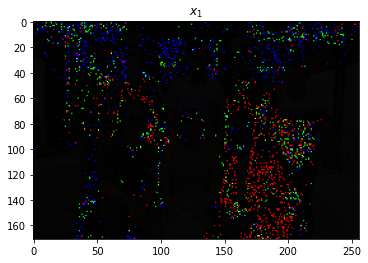

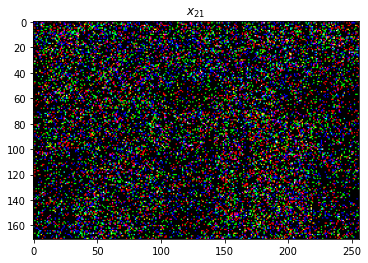

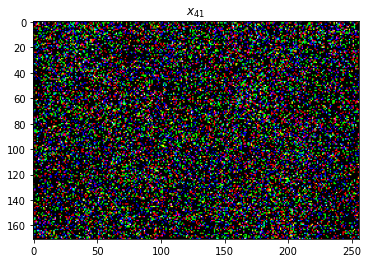

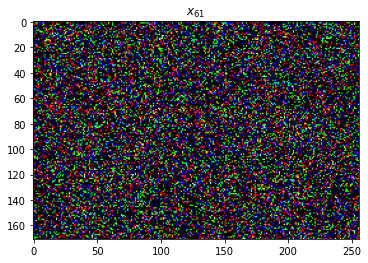

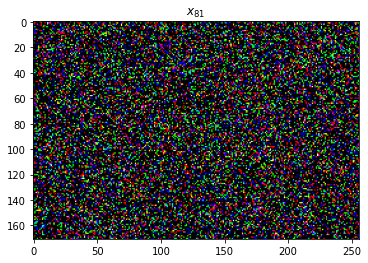

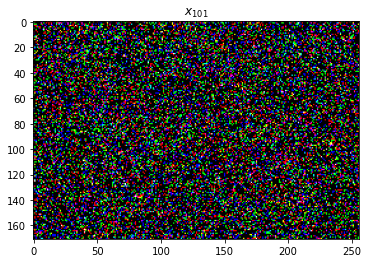

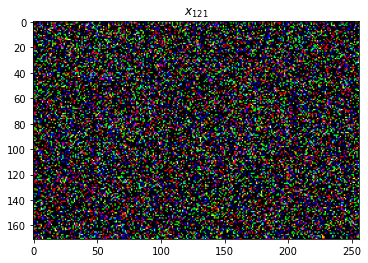

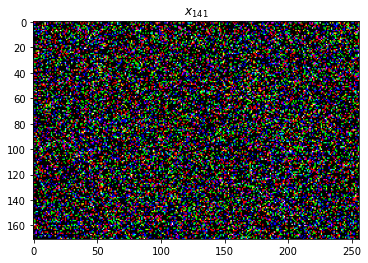

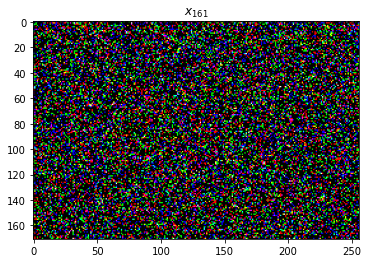

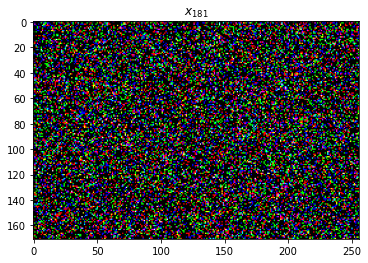

In [10]:
from matplotlib import pyplot as plt
"""
Jonathan Ho, Ajay Jain, Pieter Abbeel (2020), Denoising Diffusion Probabilistic Models
recommends the beta should from 0.0001 to 0.02
"""
scheduler_end = 0.02
for t in range(1, 201, 20):
  model = GaussianDiffusion(Beta(0.0001, scheduler_end, t), schedulerType= Beta.schedule.cosin)
  data = model.q_sample(np.array(img), t)
  plt.imshow(data.astype('uint8'))
  plt.title("$x_{"f"{t}""}$")
  plt.show()

In [ ]:
from torch import nn
class UNet(nn.Module):
  """
  please please please read Olaf Ronneberger, Philipp Fischer, Thomas Brox (2015),
  U-Net: Convolutional Networks for Biomedical Image Segmentation
  The structure is downsampling and upsampling, and connecting to each blocks.
  """
  class Conv3x3ReLU(nn.Module):
    def __init__(self, insize, out, padding = 0, dim = 2):
      super().__init__()
      class_nd = getattr(nn, f"Conv{dim}d") # exception if not found
      self.conv0 = class_nd( in_channels = insize, out_channels = out,
                            kernel_size = 3, padding = 0, bias = False,)
      self.relu0 = nn.ReLU(inplace=True)
      self.conv1 = class_nd( in_channels = out, out_channels = out,
                            kernel_size = 3, padding = 0, bias = False,)
      self.relu1 = nn.ReLU(inplace=True)

    def forward(self, x):
      for i in range(2):
        x = getattr(self, f"relu{i}")(getattr(self, f"conv{i}")(x))
      return x

  class MaxPooling2x2(nn.Module):
    def __init__(self, dim = 2):
      maxpool_nd = getattr(nn, f"MaxPool{dim}d")
      self.pooling = maxpool_nd(kernel_size = 2)

    def forward(self, x):
      return self.pooling(x)

  class UpPooling(nn.Module):
    def __init(self, insize, out, dim = 2, mode = None, kernelsize = 2):
      if mode:
        class_nd = getattr(nn, f"Conv{dim-1}d")
        self.sample = nn.Sequential(
            nn.Upsample(mode=mode, scale_factor=2),
            class_nd( in_channels, out, kernel_size=1, groups=1, stride=1)
            )
      else:
        uplearnableclass = getattr(nn, f"ConvTranspose{dim}d")
        self.sample = uplearnableclass(kernel_size = kernelsize)
    def forward(self, x):
      return self.sample(x)

  def __init__(self, input_size):
    ...

references    
DeepFindr https://www.youtube.com/watch?v=a4Yfz2FxXiY    
OpenAI https://github.com/openai/guided-diffusion    
Berkeley https://www.youtube.com/watch?v=687zEGODmHA   
Deep Learning https://www.deeplearningbook.org/contents/monte_carlo.html